<a href="https://colab.research.google.com/github/PalakDograCSE-AI2004/CVDL_Summer_Internship/blob/main/CNN_Image_processing__using_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# torchvision - dataset, models architectures and image transformation
# torchvision.dataset
# torchvision.models
# torchvision.transformers
# torchvision.utils.data.DataLoaders

In [ ]:
# base package
import torch
# neural network package
from torch import nn
# torchvision from image processing
import torchvision
# to load dataset from torchvision
from torchvision import datasets
# to perform transform and augmentation
from torchvision.transforms import ToTensor
import torch.nn.functional as F #for activation function
# to plot images data
import matplotlib.pyplot as plt


In [ ]:
train_data = datasets.FashionMNIST(
    root="dataset", # location where data will be downloaded
    train = True, # to download training data
    download = True, # download data if it doesn't exists
    transform = ToTensor(), # convert images into Torch tensor
    target_transform = None
    )

test_data = datasets.FashionMNIST(
    root="dataset", # location where data will be downloaded
    train = False, # to download training data
    download = True, # download data if it doesn't exists
    transform = ToTensor(), # convert images into Torch tensor
    )

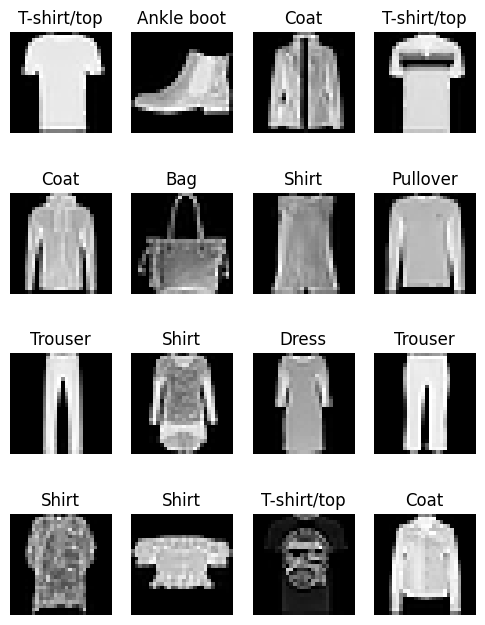

In [ ]:
class_names = train_data.classes

fig = plt.figure(figsize=(6,8))
rows = 4
cols = 4
for i in range(1, rows * cols + 1):
  # get a random number between 0 to 60000
  random_index = torch.randint(0, len(train_data), size=[1]).item()
  # get image and target of that random index
  img, target = train_data[random_index]
  # add subplot for each image
  fig.add_subplot(rows, cols, i)
  # plot image using matplotlib, cmap - set color map as grayscale
  plt.imshow(img.squeeze(), cmap="gray")
  # add title on each subplot
  plt.title(class_names[target])
  # exclude x-axis and y-axis limits
  plt.axis(False)

In [ ]:
# DataLoaders
# used to load data

# turns large dataset into smaller chunks known as batces or mini-batches
# generally we put chunk size of 32


In [ ]:
from torch.utils.data import DataLoader

In [ ]:
BATCH_SIZE = 32

train_dataLoader = DataLoader(train_data, # dataset that we to have convert into batches
                              batch_size=BATCH_SIZE, # batch size, how many samples per batch
                              shuffle=True) # shuffle data on every epoch

test_dataLoader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

In [ ]:
# Build Base Model
# class Model(nn.Module):
#   def __init__(self, input_shape, hidden_units, output_shape):
#     super().__init__()
#     self.layer_stack = nn.Sequential(
#         nn.Flatten(),   # Flatten - [1,28,28] -> [1, 28*28]
#          nn.Linear(in_features=input_shape, out_features=hidden_units),
#          nn.ReLU(),
#          nn.Linear(in_features=hidden_units, out_features=output_shape),
#          nn.ReLU()
#      )

#   def forward(self, x):
#     return self.layer_stack(x)


###########################################################################


#Build CNN Model

#conv1-first convolutional layer
#conv2d-package for 2d model
class Model(nn.Module):
  def __init__(self):
    super().__init__()
    #infeatures/in_channels=1 ie no of channels in input image(if coloured then 3 and if black and white (fashionMNIST) then 1)
    #outfeatures/out_channels=6 ie no of (filters)channels produced by convolutional
    #kernel size/Sliding window size=3 or (3,3)
    self.conv1=nn.Conv2d(1,10,(5,5))
    self.pool=nn.MaxPool2d(2,2) #pooling layer(pool_size,stride)
    #out_channels of first layer will be treated as input_channels for next layer
    self.conv2=nn.Conv2d(10,16,(5,5))
    #self.fc =self.fully_connected That is Layers of ANN
    self.fc_1=nn.Linear(16*4*4, 64)  #input neurons,hidden layer neurons
    self.fc_2=nn.Linear(64,32)       #hidden_layer neurons,output_layer
    self.fc_3=nn.Linear(32,10)       #output_layer,prediction=10 because in FashionMNIST dataset we have 10 categories/classes

  def forward(self,x):
    # apply convolutional + activation + maxpooling
    x=self.pool(F.relu(self.conv1(x))) #on first convolutional layer
    x=self.pool(F.relu(self.conv2(x))) #on second convolutional layer
    # x=torch.flatten(x,1) #apply flatten on previous x layer and convert to 1 dimension
    x=x.reshape(-1,16*4*4)
    x=F.tanh(self.fc_1(x)) #calling fc_1 and then apply relu activation function
    x=F.tanh(self.fc_2(x))  #calling fc_2 and then apply relu activation function
    x=self.fc_3(x)
    return x

In [ ]:
# input_shape = 784 - 28 * 28 = 784
# hidden_units = neurons in hidden layer
# output_shape = 10 - because we have 10 categories

#model = Model(input_shape=784, hidden_units=64, output_shape=len(class_names))

#######################################################################

#now we will create object of our model class
model=Model()

In [ ]:
model.to("cuda")

Model(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc_1): Linear(in_features=256, out_features=64, bias=True)
  (fc_2): Linear(in_features=64, out_features=32, bias=True)
  (fc_3): Linear(in_features=32, out_features=10, bias=True)
)

In [ ]:
# Evaluation metric
def accuracy(y_true, y_pred):
  # y_true = 1, y_pred = 1
  # y_true = 0, y_pred = 0
  correct_classification = torch.eq(y_true, y_pred).sum().item()
  acc = (correct_classification / len(y_pred)) * 100
  return acc

In [ ]:
# because it's a multi-classification problem that's why we are using CrossEntropy
loss_function = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

In [ ]:
def train_step(model, data_loader, loss_fn, optimizer, accuracy, device):
  train_loss, train_acc = 0, 0
  model.to(device)

  for batch, (X,y) in enumerate(data_loader):
    X,y = X.to(device), y.to(device)

    # Feedforward
    y_pred = model(X)

    # Calculate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += accuracy(y, y_pred.argmax(dim=1))
    # Backpropagate
    optimizer.zero_grad()
    # Loss Backward
    loss.backward()
    # optimizer step
    optimizer.step()

  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train Acc : {train_acc:.3f} | Train Loss : {train_loss:.3f}\n")

def test_step(model, data_loader, loss_fn, accuracy, device):
  test_loss, test_acc = 0, 0
  model.to(device)
  model.eval()

  with torch.inference_mode():
    for X,y in data_loader:
      X,y = X.to(device), y.to(device)

      # Feedforward
      y_pred = model(X)

      # Calculate loss
      loss = loss_fn(y_pred, y)
      test_loss += loss
      test_acc += accuracy(y, y_pred.argmax(dim=1))

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"\nTest Acc : {test_acc:.3f} | Test Loss : {test_loss:.3f}\n")



In [ ]:
# tqdm - used to show progress of loop
from tqdm import tqdm

epochs = 5

for epoch in tqdm(range(epochs)):
  print(f"Epoch : {epoch}\n")
  train_step(model, train_dataLoader, loss_function, optimizer, accuracy, "cuda")
  test_step(model, test_dataLoader, loss_function, accuracy, "cuda")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 0

Train Acc : 77.645 | Train Loss : 0.609



 20%|██        | 1/5 [00:14<00:57, 14.44s/it]


Test Acc : 79.523 | Test Loss : 0.557

Epoch : 1

Train Acc : 79.597 | Train Loss : 0.568



 40%|████      | 2/5 [00:28<00:42, 14.23s/it]


Test Acc : 75.310 | Test Loss : 0.662

Epoch : 2

Train Acc : 78.493 | Train Loss : 0.591



 60%|██████    | 3/5 [00:41<00:27, 13.80s/it]


Test Acc : 77.915 | Test Loss : 0.587

Epoch : 3

Train Acc : 78.818 | Train Loss : 0.585



 80%|████████  | 4/5 [00:56<00:14, 14.04s/it]


Test Acc : 77.566 | Test Loss : 0.628

Epoch : 4

Train Acc : 78.068 | Train Loss : 0.604



100%|██████████| 5/5 [01:09<00:00, 13.92s/it]


Test Acc : 77.376 | Test Loss : 0.605

